### Method 1: correlation matrix

In [3]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    return corr_array[idx, :][:, idx], idx

<AxesSubplot:>

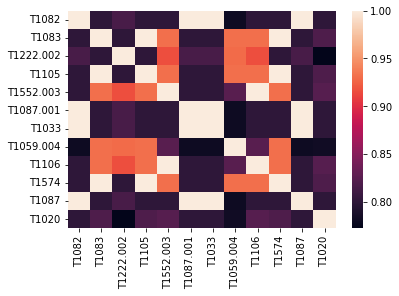

In [4]:
import os, sys
sys.path.append(os.path.abspath('../..'))

import seaborn as sns
import numpy as np
import csv
# from data.cyberkg_IBM.ttp_comb import TTPS

K = 5
cve_thre = 0.0
file = open("./save/ttp-comb-sim-%s-%s.csv" %  (str(K), str(cve_thre)))
csvreader = csv.reader(file)

# first row
header = next(csvreader) 
TTPS = header[1:]

arr = []
for row in csvreader: # contents starts with 2nd row
    arr.append([float(v) for v in row[1:]])

file.close()

arr = np.array(arr)
sns.heatmap(arr, xticklabels=TTPS, yticklabels=TTPS)

<AxesSubplot:>

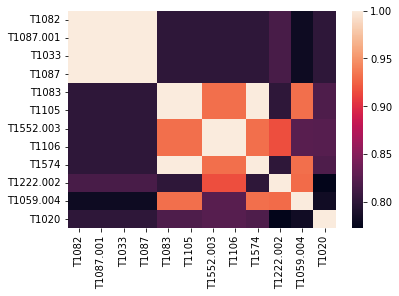

In [5]:
new_arr, idx = cluster_corr(arr)
sort_TTPS = [TTPS[i] for i in idx]
sns.heatmap(new_arr, xticklabels=sort_TTPS, yticklabels=sort_TTPS)

In [30]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 4], [1, 0],
              [1, 2], [10, 0]])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_, kmeans.cluster_centers_


(array([0, 2, 2, 0, 0, 1], dtype=int32),
 array([[ 1.        ,  1.33333333],
        [10.        ,  0.        ],
        [ 1.        ,  4.        ]]))

### Method 2: K-means

In [2]:

import os, sys
sys.path.append(os.path.abspath('../..'))

import csv
import json
import argparse
import numpy as np
from tqdm import tqdm
import networkx as nx
from collections import defaultdict
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import data.cyberkg_IBM.pkg.sysflow as sf
from data.cyberkg_IBM.pkg.sim_cve_tech import tokenize

TTPS = ['T1082', 'T1083', 'T1222.002', 'T1105', 'T1552.003', 'T1087.001', 'T1033', 'T1059.004', 'T1106', 'T1574', 'T1087', 'T1020']


In [38]:
K = 20
thre = 0.12
# cwe_list = list(sf.entset['weakness'])
# cwe_idx = {cwe: i for i, cwe in enumerate(cwe_list)}
ttp_idx = {ttp: idx for idx, ttp in enumerate(TTPS)}

cwe_list = set()
for ttp in tqdm(TTPS):
    thre_cves, thre_scores = sf.ttp_cve_link(thre = thre, tech = ttp, verbose=False)
    cwe_sort, score_sort = sf.cwe_cve_link(thre_cves, thre_scores)
    cwe_sort = cwe_sort[:K]
    cwe_list |= set(cwe_sort)
cwe_list = list(cwe_list)
cwe_idx = {cwe: i for i, cwe in enumerate(cwe_list)}

ttp_mat = np.zeros((len(TTPS), len(cwe_list)))
for ttp in tqdm(TTPS):
    thre_cves, thre_scores = sf.ttp_cve_link(thre = thre, tech = ttp, verbose=False)
    cwe_sort, score_sort = sf.cwe_cve_link(thre_cves, thre_scores)
    cwe_sort = cwe_sort[:K]
    for i, cwe in enumerate(cwe_sort):
        ttp_mat[ttp_idx[ttp]][cwe_idx[cwe]] = 1



100%|██████████| 12/12 [00:02<00:00,  4.53it/s]


In [40]:
model = KMeans(n_clusters=3, random_state=0).fit(ttp_mat)
# return kmeans.labels_, kmeans.cluster_centers_

clusters = []
for y in range(min(model.labels_), max(model.labels_)+1):
    clu = []
    for i, _y in enumerate(model.labels_):
        if y == _y:
            clu.append(TTPS[i])
    clusters.append(clu)
    
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

centers = []
for cen in model.cluster_centers_:
    dist = cdist(np.array([cen]), ttp_mat, 'euclidean')[0]
    idx = find_nearest(dist, 0)
    centers.append(TTPS[idx])

    
print(centers)
clusters

['T1087.001', 'T1059.004', 'T1574']


[['T1105', 'T1087.001', 'T1033', 'T1020'],
 ['T1552.003', 'T1059.004', 'T1106', 'T1087'],
 ['T1082', 'T1083', 'T1222.002', 'T1574']]

### Method 3: Minimum k-cuts

In [1]:
"""
Created on Fri Mar  1 18:03:10 2019
@author: Christian
Implementation (non-optimized) of the algorithm described in:
M. Thorup. Minimum k-way cuts via deterministic greedy tree packing. Proceedings of 
the Fortieth Annual ACM Symposium on Theory of Computing, 2008.

https://towardsdatascience.com/a-simple-and-fast-deterministic-algorithm-for-the-minimum-k-way-cut-74d7ee2a521a
"""
# import os, sys
# sys.path.append(os.path.abspath('../..'))
# from tqdm import tqdm
# import data.cyberkg_IBM.pkg.sysflow as sf

import networkx as nx
import numpy as np
from itertools import combinations


def min_k_way_cuts_via_deterministic_greedy_tree_packing(graph, k=3, capacity_label='weight', n_steps=-1):
    """
    Inputs:
        graph: NetworkX undirected Graph.
        k: integer number. Number of way cuts wanted.
        capacity_label: string. Networks edge label that indicates the minimization objective.
        n_steps: int number. Divides the algorithm to avoid running out of memory.
    Returns:
        min_k_way_cut: NetworkX undirected Graph (without cut edges)
    
    Description: Algorithm for finding the minimum k-way cut following the structure (non-optimized) 
    """
    
    n_nodes = graph.number_of_nodes()  # number of nodes
    n_edges = graph.number_of_edges()  # number of edges
    alpha = 1/4  # choosen alpha for the theorem
    n_trees = int(np.ceil(
            3 * n_edges * (k / alpha) ** 3 * np.log(n_nodes * n_edges * k / alpha)
            ))

    def initialize_utilization(graph, utilization='utilization'):
        nx.set_edge_attributes(graph, 0, utilization)
        return

    def get_next_tree_edges(graph, utilization='utilization', capacity='weight'):
        """
        Returns edges of the next tree and updates the graph utilization.
        Extracts the next tree by looking at the utilization of the graph
        """
        
        tree = nx.minimum_spanning_tree(graph, weight=utilization)  # edges of the spanning tree
        nx.set_edge_attributes(  # update utilizations with the utilization that would be if selected for the tree
            graph,
            {(u, v): {utilization: d[utilization] + 1/d[capacity]} for (u, v, d) in tree.edges(data=True)}
        )
    
        return tree.edges()

    def get_greedy_tree_packing(graph, n_trees, utilization, capacity, from_start=True):
        """
        Returns:
            Array of edges corresponding to the spanning tree.
        """
        if from_start:
            initialize_utilization(graph, utilization)
        else:
            pass
        return [get_next_tree_edges(graph, utilization, capacity) for _ in range(n_trees)]
    
    def get_tree_cuts(tree_edges, n_cuts=2*k-2):
        """
        Returns:
            Array of edges corresponding to the cuts of a tree
        """
        return [[(i, j) for (i, j) in tree_edges if (i, j) not in edges_rm]
                 for edges_rm in combinations(tree_edges, n_cuts)] 
    
    def get_pieces_of_cut(tree_cut, graph=graph):
        #graph_tmp = nx.Graph(graph)
        #graph_tmp.remove_edges_from(
        #        [(i, j) for (i, j) in graph_tmp.edges() if (i, j) not in tree_cut]
        #        )
        graph_tmp = nx.Graph()
        graph_tmp.add_nodes_from(graph.nodes())
        graph_tmp.add_edges_from(tree_cut)
        pieces = [list(c) for c in nx.connected_components(graph_tmp)]
        return pieces
    
    def get_combinations_of_pieces(pieces, n_groups=k):    
        """
        Returns every combination of pieces into n_groups different groups
        """
        def algorithm_u(ns, m):
            """Partitions of list ns into m groups, as posted in
            https://codereview.stackexchange.com/a/1944
            """
            
            def visit(n, a):
                ps = [[] for i in range(m)]
                for j in range(n):
                    ps[a[j + 1]].append(ns[j])
                return ps
        
            def f(mu, nu, sigma, n, a):
                if mu == 2:
                    yield visit(n, a)
                else:
                    for v in f(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                        yield v
                if nu == mu + 1:
                    a[mu] = mu - 1
                    yield visit(n, a)
                    while a[nu] > 0:
                        a[nu] = a[nu] - 1
                        yield visit(n, a)
                elif nu > mu + 1:
                    if (mu + sigma) % 2 == 1:
                        a[nu - 1] = mu - 1
                    else:
                        a[mu] = mu - 1
                    if (a[nu] + sigma) % 2 == 1:
                        for v in b(mu, nu - 1, 0, n, a):
                            yield v
                    else:
                        for v in f(mu, nu - 1, 0, n, a):
                            yield v
                    while a[nu] > 0:
                        a[nu] = a[nu] - 1
                        if (a[nu] + sigma) % 2 == 1:
                            for v in b(mu, nu - 1, 0, n, a):
                                yield v
                        else:
                            for v in f(mu, nu - 1, 0, n, a):
                                yield v
        
            def b(mu, nu, sigma, n, a):
                if nu == mu + 1:
                    while a[nu] < mu - 1:
                        yield visit(n, a)
                        a[nu] = a[nu] + 1
                    yield visit(n, a)
                    a[mu] = 0
                elif nu > mu + 1:
                    if (a[nu] + sigma) % 2 == 1:
                        for v in f(mu, nu - 1, 0, n, a):
                            yield v
                    else:
                        for v in b(mu, nu - 1, 0, n, a):
                            yield v
                    while a[nu] < mu - 1:
                        a[nu] = a[nu] + 1
                        if (a[nu] + sigma) % 2 == 1:
                            for v in f(mu, nu - 1, 0, n, a):
                                yield v
                        else:
                            for v in b(mu, nu - 1, 0, n, a):
                                yield v
                    if (mu + sigma) % 2 == 1:
                        a[nu - 1] = 0
                    else:
                        a[mu] = 0
                if mu == 2:
                    yield visit(n, a)
                else:
                    for v in b(mu - 1, nu - 1, (mu + sigma) % 2, n, a):
                        yield v
        
            n = len(ns)
            a = [0] * (n + 1)
            for j in range(1, m + 1):
                a[n - m + j] = j - 1
            return f(m, n, 0, n, a)
        
        combs = list(algorithm_u(pieces, n_groups))
        combs = [[[node for piece in group for node in piece]
                for group in groups]
                for groups in combs]
        return combs
    
    def evaluate_node_partition(node_partition, graph, capacity_label=capacity_label):
        """
        Returns an int number, the cost of the cut induced by the node partition
        """
        costs = [
                nx.cut_size(graph, node_partition[idx_0], node_partition[idx_1], capacity_label)
                for idx_0 in range(len(node_partition) - 1)
                for idx_1 in range(idx_0 + 1, len(node_partition))
                ]
        return sum(costs)
    
    if n_steps == -1:
        print('Number of trees:', n_trees)
        
        print('Starting with greedy tree packing construction...')
        enumeration = get_greedy_tree_packing(graph, n_trees, 'utilization', capacity_label)  # list of EdgeView
        print('Done')
        
        print('Starting with extraction of combinations of tree cuts...')   
        enumeration = [get_tree_cuts(tree) for tree in enumeration]
        enumeration = [edge for cut in enumeration for edge in cut]  # list of EdgeView(as list).
        print('Done') 
        
        print('Starting with extraction of pieces from cuts...')
        enumeration = [get_pieces_of_cut(cut) for cut in enumeration]
        print('Done.')
        
        print('Starting with combinations of pieces into k groups...')
        enumeration = [get_combinations_of_pieces(pieces) for pieces in enumeration]
        enumeration = [comb for combs in enumeration for comb in combs]  # list of node groupings(grouping: list of list of nodes)
        print('Done.')
        
        print('Starting with k-way cut evaluation...')
        evaluation = [evaluate_node_partition(partition, graph, capacity_label) for partition in enumeration]
        print('Done.')
        
        min_cost = np.min(evaluation)
        enumeration = [enumeration[i_partition] for i_partition in range(len(enumeration)) 
            if evaluation[i_partition] == min_cost]
    else: 
        n_trees_step = [int(np.ceil(n_trees / n_steps)) for _ in range(n_steps-1)] + [n_trees % int(np.ceil(n_trees / n_steps))]
        print('Number of trees per step:', n_trees_step)
        min_costs = [None for _ in range(n_steps)]
        enumerations = [None for _ in range(n_steps)]
        
        initialize_utilization(graph, utilization='utilization')
        
        for i_step in range(n_steps):
            print('Step', i_step + 1)
            
            print('Starting with greedy tree packing construction...')
            enumeration = get_greedy_tree_packing(graph, n_trees_step[i_step], 'utilization', capacity_label, 
                                                  from_start=False)  # list of EdgeView
            print('Done')
        
            print('Starting with extraction of combinations of tree cuts...')   
            enumeration = [get_tree_cuts(tree) for tree in enumeration]
            enumeration = [edge for cut in enumeration for edge in cut]  # list of EdgeView(as list).
            print('Done') 
        
            print('Starting with extraction of pieces from cuts...')
            enumeration = [get_pieces_of_cut(cut) for cut in enumeration]
            print('Done.')
            
            print('Starting with combinations of pieces into k groups...')
            enumeration = [get_combinations_of_pieces(pieces) for pieces in enumeration]
            enumeration = [comb for combs in enumeration for comb in combs]  # list of node groupings(grouping: list of list of nodes)
            print('Done.')
            
            print('Starting with k-way cut evaluation...')
            evaluation = [evaluate_node_partition(partition, graph, capacity_label) for partition in enumeration]
            print('Done.')
            
            min_costs[i_step] = np.min(evaluation)
            enumerations[i_step] = [enumeration[i_partition] for i_partition in range(len(enumeration)) 
            if evaluation[i_partition] == min_costs[i_step]]
        
        # merge algorithm partition into one
        min_cost = np.min(min_costs)
        enumeration = [enumerations[i_step] for i_step in range(n_steps) if min_costs[i_step] == min_cost]
        del enumerations      
        enumeration = [k_way_cut for k_way_cut_step in enumeration for k_way_cut in k_way_cut_step]
    
    return enumeration, min_cost


def generate_test_data(seed=401, n_nodes=6, edge_density=0.5, k=3):
    edge_density = edge_density
    graph_size = n_nodes
    np.random.seed(seed)
    adj_mat = np.where(np.random.random(size=(graph_size, graph_size)) < edge_density, 1, 0)
    adj_mat = adj_mat * np.random.randint(1, 30, size=(graph_size, graph_size))
    np.fill_diagonal(adj_mat, 0)
    graph = nx.Graph(adj_mat)
    return graph, k


# graph, k = generate_test_data(seed=1, n_nodes=6, edge_density=0.3, k=3)
# enumeration, min_cost = min_k_way_cuts_via_deterministic_greedy_tree_packing(graph, k=k, capacity_label='weight', n_steps=2)
print("Done")

Done


In [2]:
graph, k = generate_test_data(seed=1, n_nodes=6, edge_density=0.3, k=3)
enumeration, min_cost = min_k_way_cuts_via_deterministic_greedy_tree_packing(graph, k=k, capacity_label='weight', n_steps=2)
print("Done")

Number of trees per step: [131801, 131800]
Step 1
Starting with greedy tree packing construction...
Done
Starting with extraction of combinations of tree cuts...
Done
Starting with extraction of pieces from cuts...
Done.
Starting with combinations of pieces into k groups...
Done.
Starting with k-way cut evaluation...
Done.
Step 2
Starting with greedy tree packing construction...
Done
Starting with extraction of combinations of tree cuts...
Done
Starting with extraction of pieces from cuts...
Done.
Starting with combinations of pieces into k groups...
Done.
Starting with k-way cut evaluation...
Done.
Done


In [3]:
n_nodes = graph.number_of_nodes()  # number of nodes
n_edges = graph.number_of_edges()  # number of edges
n_nodes, n_edges

(6, 8)

In [10]:
enumeration[-1000:]

[[[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 4, 1, 3], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 3, 1, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 4, 1, 3], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 4, 1, 3], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 3, 1, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 4, 1, 3], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 4, 1, 3], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 3, 1, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 4, 1, 3], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 1, 3, 4], [2], [5]],
 [[0, 4, 1, 3], [2], [5]],
 [[0, 3, 1, 4], [2], [5]],
 

In [28]:
TTPS = ['T1082', 'T1083', 'T1222.002', 'T1105', 'T1552.003', 'T1087.001', 'T1033', 'T1059.004', 'T1106', 'T1574', 'T1087', 'T1020']

N = 3
K = 20
thre = 0
# cwe_list = list(sf.entset['weakness'])
# cwe_idx = {cwe: i for i, cwe in enumerate(cwe_list)}
ttp_idx = {ttp: idx for idx, ttp in enumerate(TTPS)}

cwe_list = set()
for ttp in tqdm(TTPS):
    thre_cves, thre_scores = sf.ttp_cve_link(thre = thre, tech = ttp, verbose=False)
    cwe_sort, score_sort = sf.cwe_cve_link(thre_cves, thre_scores)
    cwe_sort = cwe_sort[:K]
    cwe_list |= set(cwe_sort)
cwe_list = list(cwe_list)
cwe_idx = {cwe: i for i, cwe in enumerate(cwe_list)}

ttp_mat = np.zeros((len(TTPS), len(cwe_list)))
for ttp in tqdm(TTPS):
    thre_cves, thre_scores = sf.ttp_cve_link(thre = thre, tech = ttp, verbose=False)
    cwe_sort, score_sort = sf.cwe_cve_link(thre_cves, thre_scores)
    cwe_sort = cwe_sort[:K]
    for i, cwe in enumerate(cwe_sort):
        ttp_mat[ttp_idx[ttp]][cwe_idx[cwe]] = score_sort[i]/max(score_sort[:K])


graph = nx.Graph()
graph.add_nodes_from(range(len(TTPS)+len(cwe_idx)))

w_edge = []
for i in range(len(ttp_mat)):
    for j in range(len(ttp_mat[0])):
        w_edge.append((i, j, ttp_mat[i][j]))
graph.add_weighted_edges_from(w_edge)

enumeration, min_cost = min_k_way_cuts_via_deterministic_greedy_tree_packing(graph, k=N, capacity_label='weight', n_steps=2)

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]
<ipython-input-23-63ad3eb591ef>:51: RuntimeWarning: divide by zero encountered in double_scalars
  {(u, v): {utilization: d[utilization] + 1/d[capacity]} for (u, v, d) in tree.edges(data=True)}


Number of trees per step: [9493786, 9493785]
Step 1
Starting with greedy tree packing construction...


KeyboardInterrupt: 